<a href="https://colab.research.google.com/github/DionKimmm/2019-3rd-ml-month-with-kakr/blob/master/02_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 자료 : 

https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline

# 준비 단계
* 구글 드라이브와 코랩 연동
* 캐글과 코랩 연동
* 데이터셋 다운로드

## 구글 드라이브와 코랩 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 캐글과 코랩 연동

https://github.com/DionKimmm/2019-3rd-ml-month-with-kakr/blob/master/01_Run_Kaggle_Kernel_on_Colab.ipynb

## 데이터셋 다운로드

### 경로 설정 컨트롤을 잘 해줘야 할듯 하다.

In [2]:
%cd 2019_3rd_ML_month_with_KaKR/

/content/2019_3rd_ML_month_with_KaKR


In [0]:
%mkdir -p '2019_3rd_ML_month_with_KaKR'

* 캐글 컴피티션의 Data 란에 있는 API를 이용하여 다운로드 시  -p '경로' 를 통해 경로를 지정할 수 있다.

In [4]:
!kaggle competitions download -c 2019-3rd-ml-month-with-kakr -p '/content/drive/My Drive/Colab Notebooks/2019_3rd_ML_month_with_KaKR'

class.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


* 이미지셋은 따로 폴더를 만들어 unzip 하도록 한다

In [0]:
%mkdir -p 'train'

In [6]:
!unzip train.zip -d train

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [0]:
%mkdir -p 'test'

In [8]:
!unzip test.zip -d test

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


# 데이터 탐험 준비

## 라이브러리 로드하기

In [9]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

## 파일 로드하기 

### 내 위치를 모를 경우 !pwd를 사용하여 경로를 파악합니다.

In [10]:
!pwd

/content/2019_3rd_ML_month_with_KaKR


In [11]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/2019_3rd_ML_month_with_KaKR'
os.listdir(DATA_PATH)

['class.csv',
 'test.zip',
 'train.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train',
 'test']

In [0]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# 데이터 탐험

### head() 를 써봄으로써 대략적인 칼럼을 파악할 수 있습니다.

In [13]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [14]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [15]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


### Data 누락 체크

In [16]:
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


아니 이게 어떻게 돌아가는 거지? 파헤쳐 보자

In [0]:
tempSet = set(list(df_train.img_file))

In [20]:
print(tempSet.count) # 이게 아니라

AttributeError: ignored

In [21]:
print(len(tempSet)) # 이거다!

9990


### Data 갯수

In [22]:
print("Number of Train Data : {}".format(df_train.shape[0]))
print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 9990
Number of Test Data : 6150


In [23]:
print("타겟 클래스 총 갯수 : {}".format(df_class.shape[0]))
print("Train Data의 타겟 종류 갯수 : {}".format(df_train['class'].nunique()))

타겟 클래스 총 갯수 : 196
Train Data의 타겟 종류 갯수 : 196


### 클래스 분포

Text(0.5, 1.0, '차 종류에 따른 데이터 수')

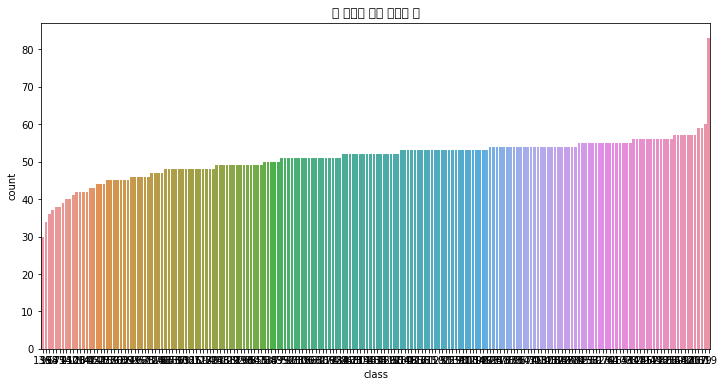

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title('차 종류에 따른 데이터 수')

### 앗 한글이 깨져버렸잖아?!
* https://github.com/DionKimmm/2019SummerML/blob/master/Day12_1_%ED%95%9C%EA%B8%80%ED%8F%B0%ED%8A%B8_%2B_ML_algorithms.ipynb

In [25]:

!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20170925-1).
fonts-nanum-coding is already the newest version (2.5-1).
fonts-nanum-eco is already the newest version (1.000-6).
fonts-nanum-extra is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fontconfig is already the newest version (2.12.6-0ubuntu2).
The following pac

다시 해보자

Text(0.5, 1.0, '차 종류에 따른 데이터 수')

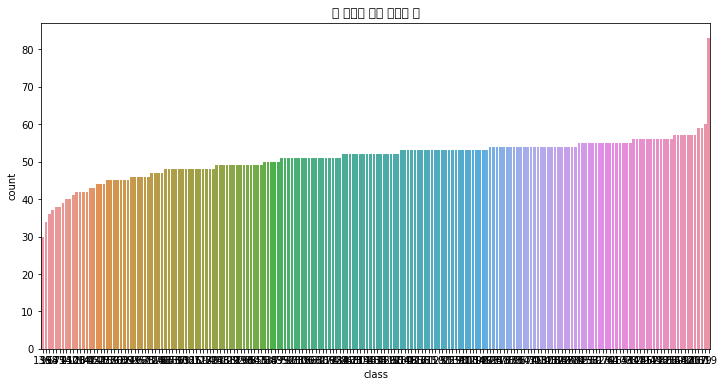

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title('차 종류에 따른 데이터 수')

또 안되네?

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
	
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
	
mpl.rcParams['axes.unicode_minus'] = False
# 그래프에서 마이너스 폰트 깨질 경우 대비
	
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

Text(0.5, 1.0, '차 종류에 따른 데이터 수')

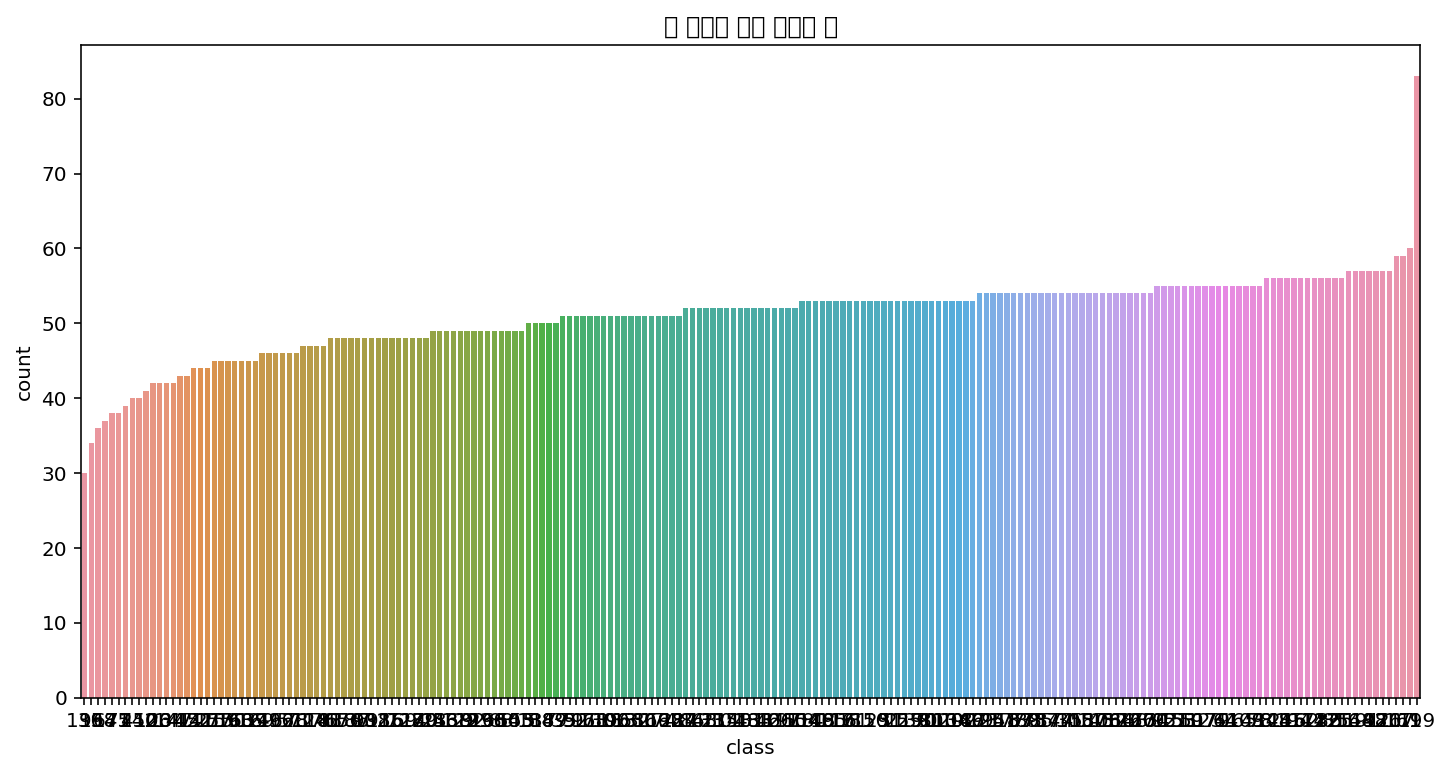

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title('차 종류에 따른 데이터 수')

Text(0.5, 1.0, '차 종류에 따른 데이터 수')

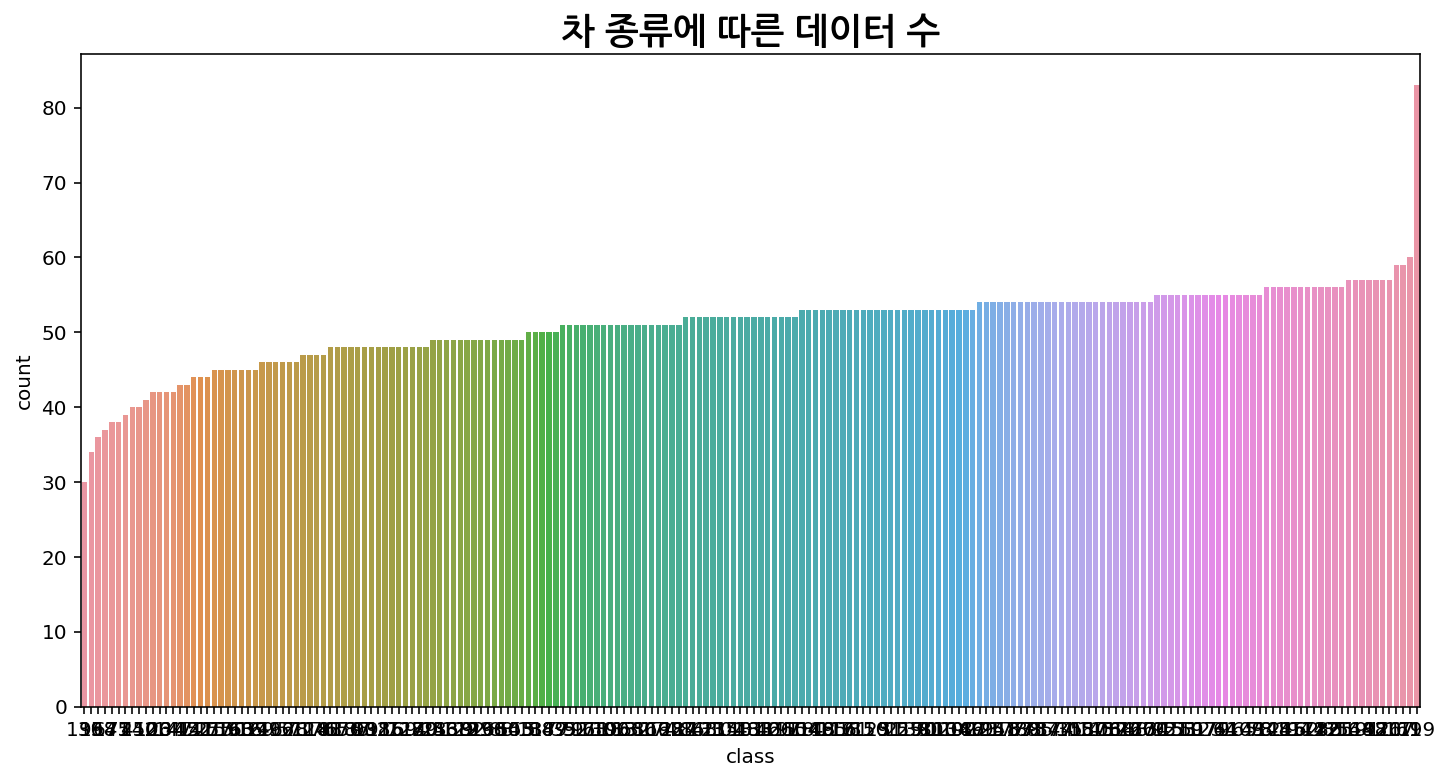

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train['class'], order=df_train['class'].value_counts(ascending=True).index)
plt.title('차 종류에 따른 데이터 수', fontproperties=fontprop)

* OLLEH!

### 사진이 가장 많은 차종과 차종의 사진 카운트 개수 알아보기

In [31]:
cntEachClass = df_train['class'].value_counts(ascending=False) #정렬 후
print(type(cntEachClass))
print(cntEachClass)

<class 'pandas.core.series.Series'>
119    83
79     60
161    59
167    59
20     57
171    57
98     57
182    57
191    57
144    57
56     57
65     56
81     56
82     56
112    56
72     56
114    56
162    56
194    56
115    56
24     56
148    56
8      56
73     55
43     55
109    55
165    55
1      55
44     55
6      55
       ..
62     46
116    46
49     46
69     46
39     45
12     45
60     45
163    45
150    45
159    45
157    45
27     44
41     44
152    44
42     43
47     43
141    42
134    42
26     42
100    42
10     41
142    40
45     40
2      39
71     38
175    38
64     37
158    36
99     34
136    30
Name: class, Length: 196, dtype: int64


In [32]:
print("Class with most count  : {}".format(cntEachClass.index[0]))
print("Most Count : {}".format(cntEachClass.max()))

print("Class with fewest count  : {}".format(cntEachClass.index[-1]))
print("Fewest Count : {}".format(cntEachClass.min()))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 119
Most Count : 83
Class with fewest count  : 136
Fewest Count : 30
Mean  : 50.96938775510204


* 평균은 50.9번, 그러니까 대략 51번. 
* 가장 많은 사진이 있는 클래스는 index[0]으로
* 가장 적은 사진의 클래스는 index[-1]로 맨 마지막 인덱스를 불러올 수 있습니다.

* 근데 더 쉬운 방법이 있음

In [33]:
cntEachClass.describe()

count    196.000000
mean      50.969388
std        5.374115
min       30.000000
25%       48.000000
50%       52.000000
75%       54.000000
max       83.000000
Name: class, dtype: float64

In [0]:
## 이미지 시각화

# 모델

# 제출